Generating Synttic sentimes analysis data


In [1]:
import sys
sys.path.append("../")
from MiniTransformersModels.Minibert import MiniBert
import torch
import random
import numpy as np

# ==========================================
# VOCABULAIRE POUR SENTIMENT ANALYSIS
# ==========================================

vocab = {
    0: "<PAD>", 1: "<CLS>", 2: "<SEP>",
    3: "the", 4: "a", 5: "this", 6: "is", 7: "was", 8: "very", 9: "so", 10: "really",
    # Sujets
    11: "movie", 12: "film", 13: "book", 14: "food", 15: "restaurant", 
    16: "place", 17: "product", 18: "service", 19: "experience", 20: "day",
    # Mots positifs
    21: "great", 22: "amazing", 23: "excellent", 24: "wonderful", 25: "fantastic",
    26: "good", 27: "love", 28: "loved", 29: "perfect", 30: "beautiful",
    31: "best", 32: "awesome", 33: "incredible", 34: "nice", 35: "happy",
    # Mots négatifs
    36: "bad", 37: "terrible", 38: "awful", 39: "horrible", 40: "worst",
    41: "hate", 42: "hated", 43: "poor", 44: "disappointing", 45: "boring",
    46: "sad", 47: "angry", 48: "waste", 49: "never", 50: "regret",
    # Mots neutres/connecteurs
    51: "and", 52: "but", 53: "not", 54: "never", 55: "always",
    56: "i", 57: "it", 58: "my", 59: "me", 60: "recommend"
}
vocab_size = len(vocab)
word_to_id = {v: k for k, v in vocab.items()}

# Catégories
SUBJECTS = ["movie", "film", "book", "food", "restaurant", "place", "product", "service", "experience", "day"]
POSITIVE_WORDS = ["great", "amazing", "excellent", "wonderful", "fantastic", "good", "love", "loved", "perfect", "beautiful", "best", "awesome", "incredible", "nice", "happy"]
NEGATIVE_WORDS = ["bad", "terrible", "awful", "horrible", "worst", "hate", "hated", "poor", "disappointing", "boring", "sad", "angry", "waste", "regret"]
INTENSIFIERS = ["very", "so", "really"]


# ==========================================
# GÉNÉRATION DE PHRASES AVEC SENTIMENT
# ==========================================

def generate_positive_sentence():
    """Génère une phrase avec sentiment positif (label=1)"""
    templates = [
        lambda: ["this", random.choice(SUBJECTS), "is", random.choice(POSITIVE_WORDS)],
        lambda: ["the", random.choice(SUBJECTS), "was", random.choice(INTENSIFIERS), random.choice(POSITIVE_WORDS)],
        lambda: ["i", random.choice(["love", "loved"]), "this", random.choice(SUBJECTS)],
        lambda: ["this", "is", "the", "best", random.choice(SUBJECTS)],
        lambda: ["a", random.choice(POSITIVE_WORDS), random.choice(SUBJECTS)],
        lambda: [random.choice(INTENSIFIERS), random.choice(POSITIVE_WORDS), random.choice(SUBJECTS)],
        lambda: ["i", "recommend", "this", random.choice(SUBJECTS)],
        lambda: ["the", random.choice(SUBJECTS), "is", random.choice(POSITIVE_WORDS), "and", random.choice(POSITIVE_WORDS)],
        lambda: ["my", random.choice(SUBJECTS), "was", random.choice(POSITIVE_WORDS)],
        lambda: ["this", random.choice(SUBJECTS), "is", random.choice(INTENSIFIERS), random.choice(POSITIVE_WORDS)],
    ]
    template = random.choice(templates)
    return template()


def generate_negative_sentence():
    """Génère une phrase avec sentiment négatif (label=0)"""
    templates = [
        lambda: ["this", random.choice(SUBJECTS), "is", random.choice(NEGATIVE_WORDS)],
        lambda: ["the", random.choice(SUBJECTS), "was", random.choice(INTENSIFIERS), random.choice(NEGATIVE_WORDS)],
        lambda: ["i", random.choice(["hate", "hated"]), "this", random.choice(SUBJECTS)],
        lambda: ["this", "is", "the", "worst", random.choice(SUBJECTS)],
        lambda: ["a", random.choice(NEGATIVE_WORDS), random.choice(SUBJECTS)],
        lambda: [random.choice(INTENSIFIERS), random.choice(NEGATIVE_WORDS), random.choice(SUBJECTS)],
        lambda: ["never", "recommend", "this", random.choice(SUBJECTS)],
        lambda: ["the", random.choice(SUBJECTS), "is", random.choice(NEGATIVE_WORDS), "and", random.choice(NEGATIVE_WORDS)],
        lambda: ["my", random.choice(SUBJECTS), "was", random.choice(NEGATIVE_WORDS)],
        lambda: ["this", random.choice(SUBJECTS), "is", random.choice(INTENSIFIERS), random.choice(NEGATIVE_WORDS)],
        lambda: ["this", "is", "a", "waste"],
        lambda: ["i", "regret", "this", random.choice(SUBJECTS)],
    ]
    template = random.choice(templates)
    return template()


# ==========================================
# CRÉATION DU DATASET DE CLASSIFICATION
# ==========================================

def generate_sentiment_classification_data(n_samples=1000, seq_len=12):
    """
    Génère un dataset pour classification binaire de sentiments
    Label 1 = Positif, Label 0 = Négatif
    """
    sequences = []
    labels = []
    
    for _ in range(n_samples):
        # 50% positif, 50% négatif
        is_positive = random.random() < 0.5
        
        if is_positive:
            sentence = generate_positive_sentence()
            label = 1
        else:
            sentence = generate_negative_sentence()
            label = 0
        
        # Format BERT: <CLS> + phrase + <SEP>
        seq = [word_to_id["<CLS>"]]
        seq += [word_to_id[w] for w in sentence]
        seq += [word_to_id["<SEP>"]]
        
        # Padding
        while len(seq) < seq_len:
            seq.append(word_to_id["<PAD>"])
        
        seq = seq[:seq_len]
        
        sequences.append(seq)
        labels.append(label)
    
    return torch.tensor(sequences, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


# ==========================================
# PRÉPARATION DES DONNÉES TRAIN/TEST
# ==========================================

def prepare_sentiment_data(n_train=5000, n_test=1000, seq_len=12):
    """
    Prépare les datasets d'entraînement et de test
    """
    # Générer train
    x_train, y_train = generate_sentiment_classification_data(n_train, seq_len)
    
    # Générer test
    x_test, y_test = generate_sentiment_classification_data(n_test, seq_len)
    
    return x_train, y_train, x_test, y_test


# ==========================================
# AFFICHAGE D'EXEMPLES
# ==========================================

def decode_sequence(seq):
    """Décode une séquence de tokens en mots"""
    return [vocab[i.item()] for i in seq if i.item() != word_to_id["<PAD>"]]


# ==========================================
# GÉNÉRATION ET AFFICHAGE
# ==========================================

print("=" * 70)
print("GÉNÉRATION DE DONNÉES POUR BERT - CLASSIFICATION DE SENTIMENTS")
print("=" * 70)

# Générer les données
x_train, y_train, x_test, y_test = prepare_sentiment_data(n_train=5000, n_test=1000, seq_len=12)

print(f"\n📊 Statistiques du dataset:")
print(f"   Vocab size: {vocab_size}")
print(f"   Séquence length: {x_train.shape[1]}")
print(f"   Train samples: {len(x_train)}")
print(f"   Test samples: {len(x_test)}")
print(f"   Positifs train: {(y_train == 1).sum().item()}")
print(f"   Négatifs train: {(y_train == 0).sum().item()}")

print(f"\n📝 Exemples de phrases générées:")
print("-" * 70)

# Afficher 10 exemples
for i in range(10):
    decoded = decode_sequence(x_train[i])
    sentiment = "😊 POSITIF" if y_train[i].item() == 1 else "😞 NÉGATIF"
    print(f"{i+1}. [{sentiment}] {' '.join(decoded)}")



GÉNÉRATION DE DONNÉES POUR BERT - CLASSIFICATION DE SENTIMENTS

📊 Statistiques du dataset:
   Vocab size: 61
   Séquence length: 12
   Train samples: 5000
   Test samples: 1000
   Positifs train: 2503
   Négatifs train: 2497

📝 Exemples de phrases générées:
----------------------------------------------------------------------
1. [😞 NÉGATIF] <CLS> really disappointing restaurant <SEP>
2. [😊 POSITIF] <CLS> very excellent book <SEP>
3. [😊 POSITIF] <CLS> the service is amazing and loved <SEP>
4. [😞 NÉGATIF] <CLS> my product was regret <SEP>
5. [😞 NÉGATIF] <CLS> i regret this book <SEP>
6. [😞 NÉGATIF] <CLS> the book was so regret <SEP>
7. [😞 NÉGATIF] <CLS> very bad experience <SEP>
8. [😞 NÉGATIF] <CLS> i regret this movie <SEP>
9. [😞 NÉGATIF] <CLS> the experience was so disappointing <SEP>
10. [😞 NÉGATIF] <CLS> i hate this product <SEP>


Training On data 

In [2]:
bert=MiniBert("adam","BinaryCrossentropy",vocab_size,128,1)
train_losses,val_losses,accs,val_accs=bert.minibatch_SGD_train(10,x_train[500:],y_train[500:].unsqueeze(1),x_test[500:],y_test[500:].unsqueeze(1),batch_size=32,learning_rate=0.001,accuracy=True)

1 | Train Loss: 0.9774 | Val Loss: 0.8879 | Train Acc: 100.00% | Val Acc: 100.00%
2 | Train Loss: 0.9092 | Val Loss: 0.7603 | Train Acc: 100.00% | Val Acc: 100.00%
3 | Train Loss: 0.7752 | Val Loss: 0.5513 | Train Acc: 100.00% | Val Acc: 100.00%
4 | Train Loss: 0.5535 | Val Loss: 0.5802 | Train Acc: 100.00% | Val Acc: 100.00%
5 | Train Loss: 0.5686 | Val Loss: 0.6049 | Train Acc: 100.00% | Val Acc: 100.00%
6 | Train Loss: 0.5853 | Val Loss: 0.5402 | Train Acc: 100.00% | Val Acc: 100.00%
7 | Train Loss: 0.5231 | Val Loss: 0.4878 | Train Acc: 100.00% | Val Acc: 100.00%
8 | Train Loss: 0.4694 | Val Loss: 0.4856 | Train Acc: 100.00% | Val Acc: 100.00%
9 | Train Loss: 0.4650 | Val Loss: 0.5091 | Train Acc: 100.00% | Val Acc: 100.00%
10 | Train Loss: 0.4841 | Val Loss: 0.5059 | Train Acc: 100.00% | Val Acc: 100.00%


Ploting the results


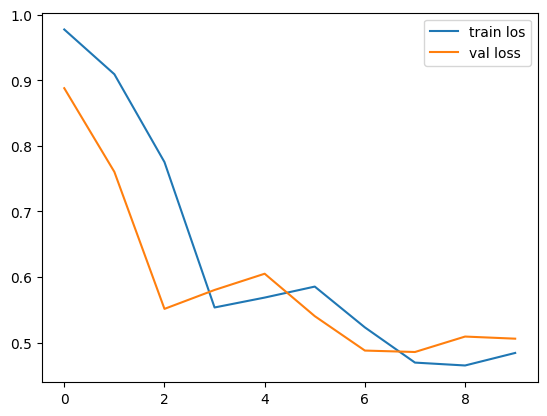

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),train_losses,label="train los")
plt.plot(range(len(train_losses)),val_losses,label="val loss")
plt.legend()



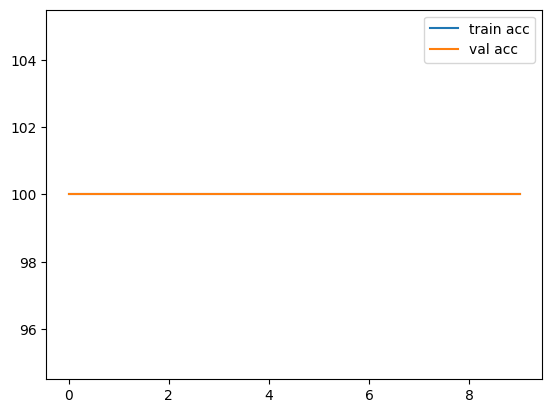

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),accs,label="train acc")
plt.plot(range(len(train_losses)),val_accs,label="val acc")
plt.legend()